In [41]:
import os
import re
import math
import tensorflow as tf
import numpy as np

from PIL import Image,ImageFilter
from tensorflow.keras import layers
import tensorflow.keras.backend as K

In [40]:
import PIL 
PIL.__version__

'10.1.0'

In [37]:
def displaySideBySide(images, scale=0.5, rows=1):
    w,h = images[0].size
    w = int(w*scale)
    h = int(h*scale)
    height = rows*h
    cols = math.ceil(len(images) / rows)
    width = cols*w
    canvas = Image.new('RGBA', (width,height), 'white')
    for i,img in enumerate(images):
        img = img.resize((w,h), Image.LANCZOS)
        canvas.paste(img, (w*(i % cols), h*(i // cols))) 
    return canvas

In [30]:
class Argmax(layers.Layer):
    def __init__(self, **kwargs):
        super(Argmax, self).__init__(**kwargs)

    def call(self, inputs, mask=None):
        return K.argmax(inputs, axis=-1)
    
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)
    
class Greyscale(layers.Layer):
    def __init__(self, **kwargs):
        super(Greyscale, self).__init__(**kwargs)
        self.whites = tf.constant(255,shape=[512,512],dtype=tf.uint8)
        self.blacks = tf.constant(0,shape=[512,512],dtype=tf.uint8)
    def call(self,inputs):
        # includeFaceHairAndNeck = tf.logical_or(tf.equal(inputs,2),tf.logical_or(tf.equal(inputs,13),tf.equal(inputs,10)))
        includeFaceAndHair = tf.logical_or(tf.logical_or(tf.equal(inputs,2),tf.equal(inputs,13)),tf.logical_or(tf.equal(inputs,4),tf.equal(inputs,6)))
        # outputs = tf.where(tf.equal(inputs,13),self.whites,self.blacks)
        outputs = tf.where(includeFaceAndHair,self.whites,self.blacks)
        outputs = tf.expand_dims(outputs,axis=-1)
        return tf.cast(outputs,tf.uint8)
        # return tf.cast(inputs * 12,tf.uint8)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [31]:
def Predictor(image_size=512):
    model_input = tf.keras.Input(shape=(image_size, image_size, 3))
    resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=model_input)
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)
    input_a = layers.UpSampling2D(size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),interpolation="bilinear")(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(size=(image_size // x.shape[1], image_size // x.shape[2]), interpolation="bilinear")(x)
    model_output = layers.Conv2D(20, kernel_size=(1, 1), padding="same")(x)
    return tf.keras.Model(inputs=model_input, outputs=model_output)


predictor = Predictor(image_size=512)

In [32]:
seq = tf.keras.Sequential(
    [
        predictor,
        Argmax(),
        Greyscale() 
    ]
)

In [33]:
seq.load_weights("weights.h5")

In [73]:
img = Image.open("kids.jpg").resize((512,512))
arr = np.expand_dims(np.array(img)/127.5 - 1,0)
res = seq(arr).numpy().squeeze()
result = Image.composite(img.filter(ImageFilter.GaussianBlur(3)),img,Image.fromarray(res))

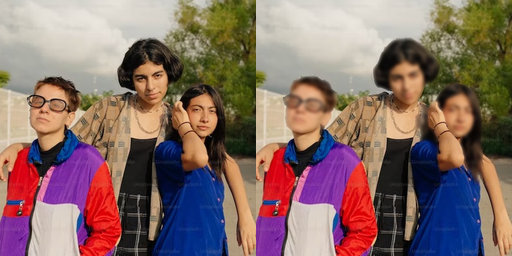

In [38]:
displaySideBySide([img,result])